# Harris Corner Detection

In this notebook the rotation of an image will be estimated by matching ponits using Harris Corner Detection.

The Harris Corner Detection uses the sobel vertical and horizontal filter. We then create a new image of the form $I_x^2, I_x \times I_y, I_y^2$. This image is then blurred with a gaussian convolution and then the corner response is then output.

Consider that at a corner at $x$ and $y$, we expect $I_x^2$ and $I_y^2$ to be high. At nearby edges, we will see either a high $I_x^2$ or a high $I_y^2$ but not a high $I_x \times I_y$. The corner point its self will have a low reponse on its own.

Two neighbouring points will have a high $I_x^2$ with low $I_y \times I_x$ and a high $I_y^2$ with low $I_y \times I_x$. Thus by taking the average we sum the high $\sum_w{I_x^2}$ and $\sum_w{I_y^2}$ and a low $\sum_w{I_y \times I_x}$.

If just $\sum_w{I_y^2}$ or just $\sum_w{I_x^2}$ were high then it would be just an edge. We want both $\sum_w{I_y^2}$ and $\sum_w{I_x^2}$ to be high and of a similiar magnitude by using some metric such as...

$\frac{\sum_w{I_y^2} \sum_w{I_x^2} - (\sum_w{I_y \times I_x})^2}{\sum_w{I_y^2} + \sum_w{I_x^2}}$.

In [34]:
# export
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import ConnectionPatch
from dataclasses import dataclass

In [2]:
import pdb
from Export.nb_HistogramEqualisation import compareTwoImages

In [3]:
# export
from Export.nb_Convolutions1D import oneDimConvolution, gaussianConv, derivative
from Export.nb_ConvertToHSV import convertToGrey
from Export.nb_PixelManipulation import getChannels, iterateImage
from Export.nb_HistogramEqualisation import compareTwoImages

## Setting up the input images

In [4]:
frog_img_pil = Image.open('Images/dat_boi.jpg')

In [5]:
rotated_frog_pil = frog_img_pil.rotate(120)

In [6]:
frog_img = np.array(frog_img_pil)
rotated_frog = np.array(rotated_frog_pil)

In [7]:
frog_img = cv2.cvtColor(frog_img, cv2.COLOR_RGB2BGR)
rotated_frog = cv2.cvtColor(rotated_frog, cv2.COLOR_RGB2BGR)

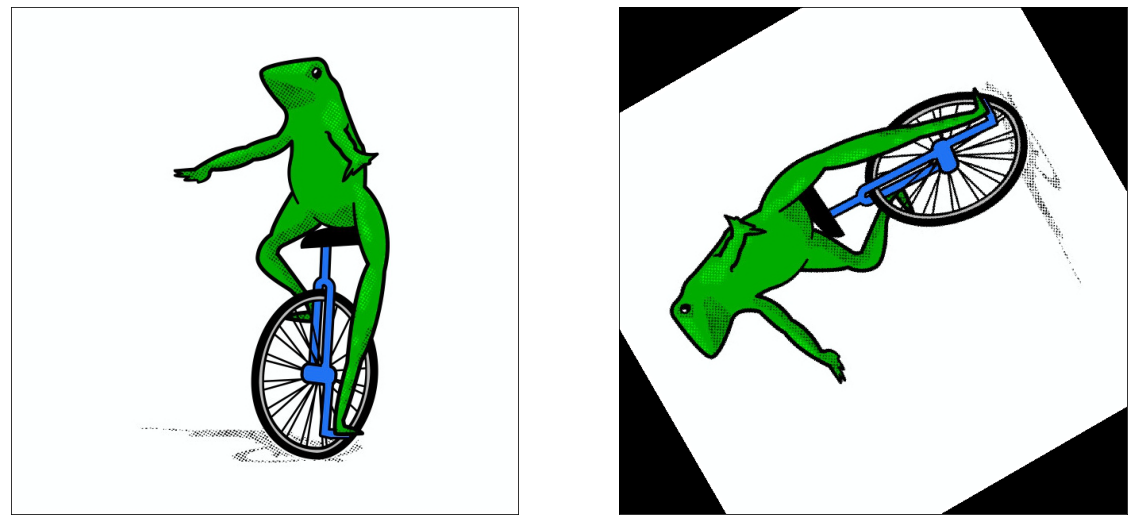

In [8]:
compareTwoImages(frog_img, rotated_frog);

In [9]:
grey_frog_img = frog_img.copy()
grey_rotated_frog = rotated_frog.copy()
grey_frog_img = convertToGrey(grey_frog_img)
grey_rotated_frog = convertToGrey(grey_rotated_frog)

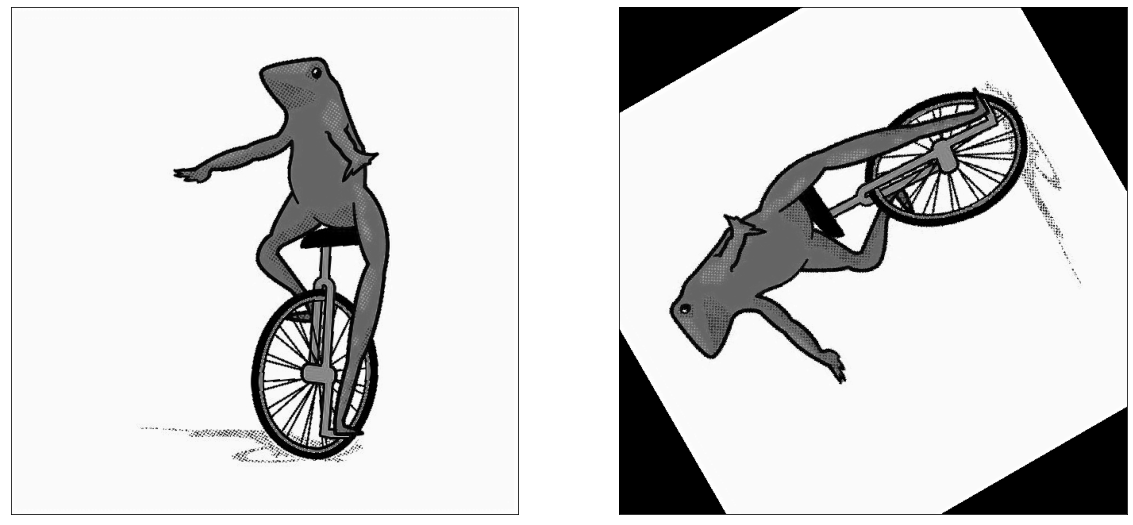

In [10]:
compareTwoImages(grey_frog_img, grey_rotated_frog, cmap = 'gray');

## Harris Corner Detection Pre-processing

Convert a greyscale image into 3 channel image containing each of the following quanitities...  $I_x^2$, $I_y^2$, $I_y \times I_x$.

In [11]:
# export
def computeGradientPolyImage(img: np.array, kernel_size: int):
    _, height, width, channels, _ = getChannels(img)
    if channels != 1 : print('Incorrect input size'); return
    hori_deriv = oneDimConvolution(img.copy(), derivative(kernel_size), True)
    vert_deriv = oneDimConvolution(img.copy(), derivative(kernel_size), False)
    output_img = np.dstack((hori_deriv, vert_deriv, np.zeros((height, width), dtype = np.float32)))
    i, j, k = 0, 0, 0
    for px in np.nditer(output_img, order = 'C', op_flags = ['readwrite']):
        if k == 0:
            current_x = px
        elif k == 1:
            current_y = px
        else:
            px[...] = current_x * current_y
            current_x[...] **= 2
            current_y[...] **= 2
        i, j, k = iterateImage(i, j, k, 3, width)
    return output_img

In [12]:
grad_frog = computeGradientPolyImage(grey_frog_img, 5)

This effect creates a disco frog. Now each channel of the image can be blurred.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


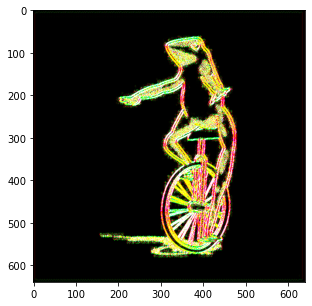

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(grad_frog/255);

## Gaussian Blur Each Channel

In order to take a window, we just take a guassian blur or each channel.

In [14]:
conv_y, conv_x = gaussianConv(7, 7)
grad_frog = oneDimConvolution(grad_frog, conv_y, False)
grad_frog = oneDimConvolution(grad_frog, conv_x, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


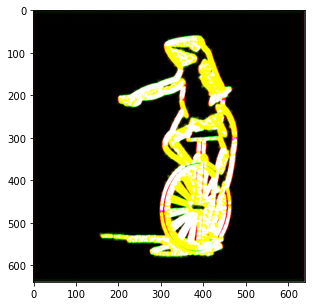

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(grad_frog/255);

## Evaluate Corner Potential of 'Gradient Poly' Image

Define a function that takes in $I_x^2$, $I_y^2$, $I_y \times I_x$  and outputs a measure of 'cornerness'. The function also gives a magitude and an angle.

In [16]:
# export
def determinantOverTrace(Ix2: float, Iy2: float, IyIx: float):
    trace = Ix2 + Iy2
    det = Ix2*Iy2 - IyIx**2
    angle = Ix2 - Iy2
    if angle == 0:
        np.pi/2 * np.sign(IyIx)
    else:
        angle = np.arctan(2*IyIx/angle)/2
    if trace == 0: return 0, 0, 0
    return (trace + 2*det, angle, det/trace)

In [17]:
# export
def updateMinMaxChannels(output_vector: tuple, max_channels: dict, min_channels: dict):
    for channel in max_channels.keys():
        if output_vector[channel] > max_channels[channel]:
            max_channels[channel] = output_vector[channel]
        if output_vector[channel] < min_channels[channel]:
            min_channels[channel] = output_vector[channel]
            
def divideByMaxChannels(img: np.array, max_channels: dict, min_channels: dict):
    for channel, max_channel in max_channels.items():
        min_channel = min_channels[channel]
        img[:, :, channel] -= min_channel
        max_channel -= min_channel
        if max_channel > 0: img[:, :, channel] /= max_channel

def computeCornerMeasure(img: np.array, cornerMeasure):
    _, _, width, channels, _ = getChannels(img)
    if channels != 3 : print('Incorrect numer of input channels'); return
    i, j, k = 0, 0, 0
    max_channels = {0:0,1:0,2:0}
    min_channels = {0:0,1:0,2:0}
    for px in np.nditer(img, order = 'C', op_flags = ['readwrite']):
        if k == 0:
            current_x = px
        elif k == 1:
            current_y = px
        else:
            output_vector = cornerMeasure(current_x, current_y, px)
            current_x[...] = output_vector[0] 
            current_y[...] = output_vector[1]
            px[...] = output_vector[2]
            updateMinMaxChannels(output_vector, max_channels, min_channels)
        i, j, k = iterateImage(i, j, k, 3, width)
    divideByMaxChannels(img, max_channels, min_channels)
    return img

In [18]:
harris_frog = computeCornerMeasure(grad_frog, determinantOverTrace)

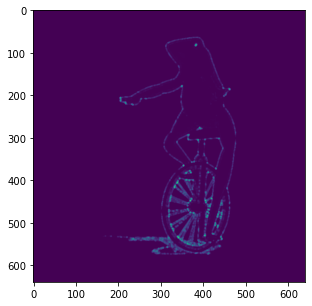

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(harris_frog[:,:,0]);

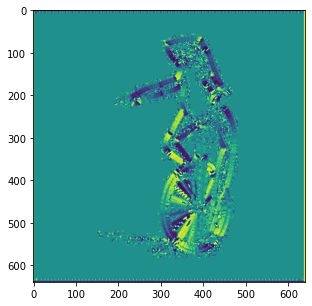

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(harris_frog[:,:,1]);

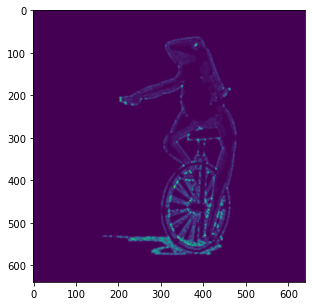

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(harris_frog[:,:,2]);

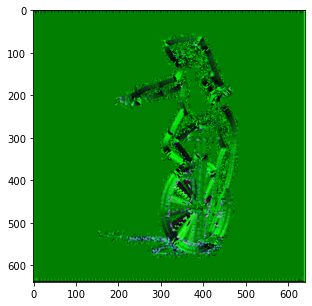

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(harris_frog);

## Converting the Two Images

Now all the above functions are put into a single function that turns a greyscale image into a harris corner output. There are three channels for the corner output: the magnitude, the angle between eigen vectors and the energy function used to a find a threshold for corners.

In [23]:
# export
def harrisCornerImage(img : np.array, derivative_size: int, blur_size: int, energyFunction):
    grad_frog = computeGradientPolyImage(img, derivative_size)
    conv_y, conv_x = gaussianConv(7, 7)
    grad_frog = oneDimConvolution(grad_frog, conv_y, False)
    grad_frog = oneDimConvolution(grad_frog, conv_y, True)
    return computeCornerMeasure(grad_frog, energyFunction)

In [24]:
initial_harris = harrisCornerImage(grey_frog_img, 7, 5, determinantOverTrace)

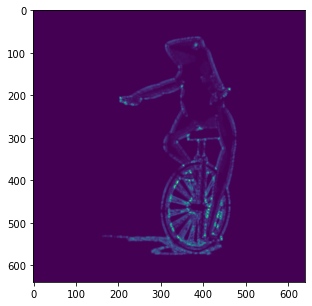

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(initial_harris[:,:,2]);

In [26]:
rotated_harris = harrisCornerImage(grey_rotated_frog, 7, 5, determinantOverTrace)

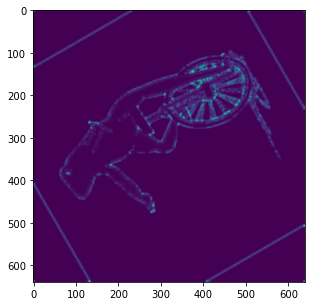

In [27]:
plt.figure(figsize=(5,5))
plt.imshow(rotated_harris[:,:,2]);

## Drawing on Two Images Given Matches With Different Strengths

Matches will be stored in a dictionary where two points are stored along with their matching affinity.

In [28]:
test_matches = [
    ((300, 320), (320, 200), 20),
    ((320, 300), (320, 200), 50),
    ((200, 220), (350, 120), 255)
]

In [29]:
# export
def connectPoint(px1: tuple, px2: tuple, target_axis: plt.axis, init_axis: plt.axis, **kwargs):
    target_axis.plot([px1[0]],[px1[1]], 'rx', markersize=10)
    con = ConnectionPatch(xyA=px1, xyB=px2, coordsA="data", coordsB="data",
                    axesA=target_axis, axesB=init_axis, **kwargs)
    target_axis.add_artist(con)

def addArrow(px1: tuple, px2: tuple, ax1: plt.axis, ax2: plt.axis, **kwargs):
    connectPoint(px1, px2, ax1, ax2, **kwargs)
    connectPoint(px2, px1, ax2, ax1, **kwargs)

In [30]:
# export
def drawArrowsOnImages(image1: np.array, image2: np.array, matches: list, cmap_image: str, cmap_match: str, **kwargs):
    cmap = matplotlib.cm.ScalarMappable(
      norm = matplotlib.colors.Normalize(0, 255), 
      cmap = cmap_match
    )
    cmap.set_array([])
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    ax1, ax2, fig = compareTwoImages(image1, image2, cmap = cmap_image)
    for match in matches:
        px1, px2, affinity = match
        kwargs['color'] = cmap.to_rgba(affinity)[:3]
        addArrow(px1, px2, ax1, ax2, **kwargs)
    fig.subplots_adjust(bottom=0.1)
    plt.colorbar(cmap, orientation='horizontal', cax = fig.add_axes([0.2, 0.05, 0.6, 0.03]));
    plt.gca().set_xlabel('Match Affinity', fontsize=16);

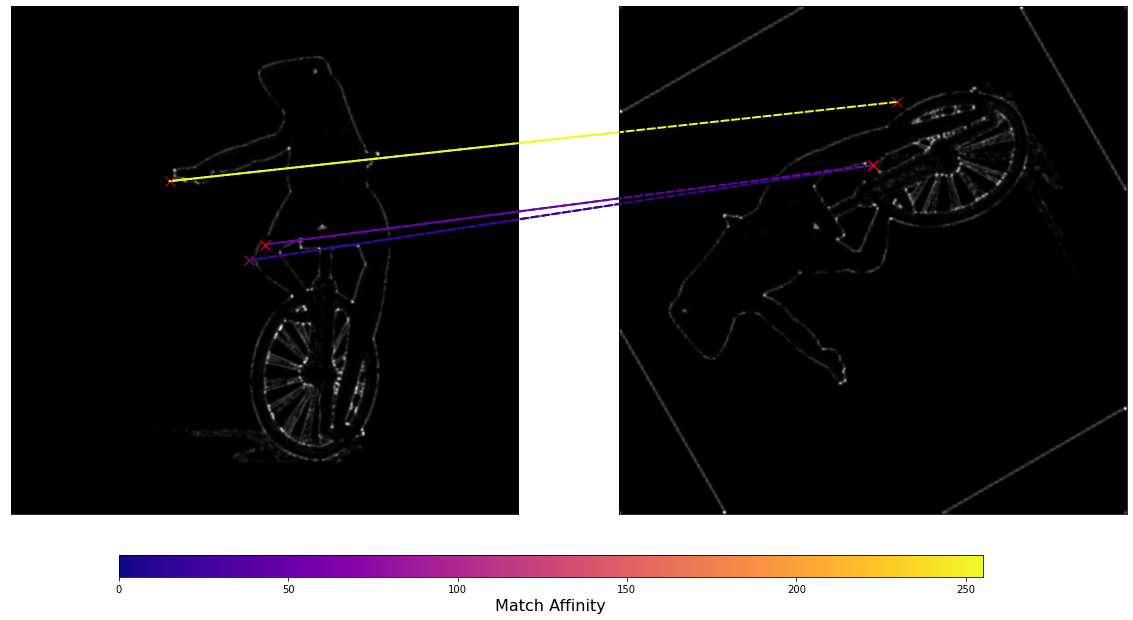

In [31]:
drawArrowsOnImages(initial_harris[:,:,0], rotated_harris[:,:,0], test_matches, 'gray', 'plasma', lw = 2.0, ls = '--')

## Finding Suitable Corners in an Image

The Harris corner image will be a masking tool to select points. Only corner points will be selected that have no previous corner points selected near them within a certain distance. There also need to be n-channel feature images to do the matching. The n-channel image is read into feature vectors for each corner detected. A matching method is then applied to calculated the simularity between each feature vector. 

The angle of Harris will be used to measure the angle change. Oriented windows could be used to find features but windows using euclidean distance (circular windows) works as well.

In [80]:
# export
@dataclass
class HarrisPoint: 
    feature_vector: np.array = np.array([], dtype = np.float32)
    coordinate: np.array = np.array([0,0], dtype = np.float32)
    magnitude: float = 0.
    angle:float = 0.
    corner_measure:float = 0.
    
    def __len__(self):
        return len(self.feature_vector)
    
    def __getitem__(self, idx):
        return self.feature_vector[idx]
    
    def distanceTo(self, point: tuple):
        distance = self.coordinate - point
        return np.dot(distance, distance)

In [81]:
test_harris = HarrisPoint(
    np.array([1,2,3,4], dtype = np.float32), 
    np.array([0,0], dtype = np.float32),
    0, 0, 0
)

In [82]:
assert(test_harris.distanceTo((2,2)) == 8.)

In [112]:
# export
class HarrisPointArray:
    def __init__(self, feature_len: int):
        self.harris_points = []
        self.template_array = np.ndarray(feature_len, dtype = np.float32)
        self.template_array.fill(0.)
        
    def addPoint(self, i: int, j: int, mag: float, angle: float, corner: float):
        new_point = HarrisPoint(
            self.template_array,
            np.array([i, j], dtype = np.float32),
            mag, angle, corner
        )
        self.harris_points.insert(0, new_point)
        
    def checkAllDistances(self, i: int, j: int, distance_thresh: float):
        new_coord = np.array([i, j], dtype = np.float32)
        for point in self.harris_points:
            if point.distanceTo(new_coord) < distance_thresh:
                return False
            else:
                if i - point.coordinate[0] > distance_thresh:
                    return True
        return True
    
    def plotPoints(self, img: np.array, **kwargs):
        plt.imshow(img, **kwargs)
        for point in self.harris_points:
            plt.scatter(*reversed(point.coordinate))
    
    def __len__(self):
        return len(self.harris_points)

In [113]:
# export
def thresholdHarrisWithinDistance(harris_img: np.array, corner_thresh: float, distance_thresh: float, feature_len: int):
    _, _, width, channels, _ = getChannels(harris_img)
    if channels != 3 : print('Incorrect numer of input channels'); return
    i, j, k = 0, 0, 0
    distance_thresh **= 2
    harris_points = HarrisPointArray(feature_len)
    for px in np.nditer(harris_img, order = 'C', op_flags = ['readwrite']):
        if k == 0:
            curr_x = px
        elif k == 1:
            curr_y = px
        else:
            if px > corner_thresh:
                if harris_points.checkAllDistances(i, j, distance_thresh):
                    harris_points.addPoint(i, j, curr_x, curr_y, px)
        i, j, k = iterateImage(i, j, k, 3, width)
    return harris_points

The function call below find corner points in the top 10% of matches and no two points should be close then 10 pixels. There is a fixed sized feature array declared for each Harris point.

In [114]:
harris_points = thresholdHarrisWithinDistance(harris_frog, 0.9, 10., 10)

In [115]:
len(harris_points)

16

We can plot all the Harris points detected. There are a lot of them around the wheel and some other good ones around the seat.

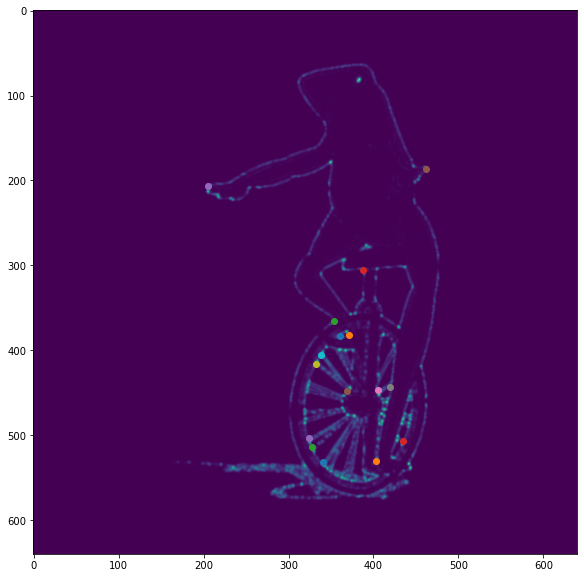

In [117]:
plt.figure(figsize=(10,10))
harris_points.plotPoints(harris_frog[:,:,0])

## Matching Similiarity of Feature Images

First two feature images will be created using the rotated an unrotated image. Each channel should be normalised before any comparisions are made. Rotationally invariant windows are used to make histograms which function as feature vectors. The feature vectors are then added to Harris Points.

The feature images that will be used is the derivative magnitude channel (which is already available from Harris Corner Detections) and the original greyscale channel. Additional channels can be added.

In [118]:
def createFeatureImage(*args):
    pass

In [119]:
def getFeatureVectorsFromCornerPoints():
    pass

In [ ]:
def dotProductSimiliarity():
    pass

## Using the Matches to Estimate Rotation

In [ ]:
def findBestHarrisMatches(min_match_ratio: float):
    pass

In [ ]:
def findRotationEstimate():
    pass

## Putting it all Together

In [ ]:
def estimateRotation():
    pass

## Export